In [1]:
import pandas as pd
from pathlib import Path
import scipy.io
import numpy as np
from src.eeg_analysis.data_management import load_patient_group_labels
import matplotlib.pyplot as plt

#### Import Duan's preprocessed EEG

In [2]:
def load_mat_file(participant_id, epoch, variables):

    base_dir = Path(r'D:/Anesthesia_Research_Fellow/preprocessed_EEG_by_DuanLI')
    base_filename = f'CA_{participant_id:02}_{epoch}_denoised.mat'
    file_path = base_dir / base_filename

    # Check if the file exists
    if not file_path.exists():
        raise FileNotFoundError(f"The file {file_path} does not exist")

    # Load .mat file
    mat_data = scipy.io.loadmat(file_path)

    # Access the variables
    data = {}
    for variable in variables:
        if variable in mat_data:
            curr_variable = mat_data[variable]
            if variable in ['zz_epoch', 'zz_noise']:
                data[variable] = np.transpose(curr_variable, [1, 0])
            elif variable in ['channels_remained', 'Index_tt']:
                data[variable] = curr_variable.flatten() - 1 # Due to Python zero-indexing
            elif variable in ['fs', 'L_raw', 'L_denoised']:
                data[variable] = curr_variable.flatten()[0]
            else:
                data[variable] = curr_variable.flatten()
        else:
            print(f"The variable '{variable}' does not exist in the .mat file for epoch '{epoch}'")
    
    return data

In [3]:
# Load the patient group labels
main_dir = 'E:/Caffeine_data/'

group_labels_file_path = 'E:/Caffeine_data/caffeine_labels.xlsx'
groups = load_patient_group_labels(group_labels_file_path)

BLUE = "#1f3b73"  # Dark Blue
RED = "#a82323"  # Dark Red

variables = ['tt']
if groups is not None:

    drug_infusion_to_extubation = {p_name:[] for p_name in groups['A']+groups['B']}

    # Load the data
    group_label = {}
    for p_idx, p_name in enumerate((groups['A']+groups['B'])):
        if p_name in groups['A']:
            group_label[p_name] = 'A'
        elif p_name in groups['B']:
            group_label[p_name] = 'B'
        else:
            group_label[p_name] = np.nan

        participant_id = p_name.split('-')[1]

        drug_infusion_to_extubation[p_name] = load_mat_file(participant_id, 'preExtube', variables)['tt'].max()/250/60 

Excel file loaded successfully.
Column names: Index(['Patient_Label', 'Group_Number', 'Raw_Data_Available',
       'Preprocessed_Data_Available', 'Valid MAC_and_normal_closure'],
      dtype='object')
{'A': ['CA-03', 'CA-05', 'CA-07', 'CA-10', 'CA-11', 'CA-13', 'CA-15', 'CA-18', 'CA-19', 'CA-26', 'CA-27', 'CA-38', 'CA-40', 'CA-42', 'CA-52', 'CA-55', 'CA-63', 'CA-64', 'CA-66', 'CA-71'], 'B': ['CA-01', 'CA-02', 'CA-04', 'CA-06', 'CA-09', 'CA-14', 'CA-21', 'CA-24', 'CA-25', 'CA-28', 'CA-29', 'CA-34', 'CA-36', 'CA-48', 'CA-49', 'CA-53', 'CA-54', 'CA-56', 'CA-65', 'CA-69', 'CA-70']}
Group A: 20 subjects, Group B: 21 subjects


Group A: median 42.6 min (IQR 36.4–62.3)
Group B: median 47.0 min (IQR 37.8–61.1)
Mann–Whitney U = 194, n₁ = 20, n₂ = 21, p = 0.686


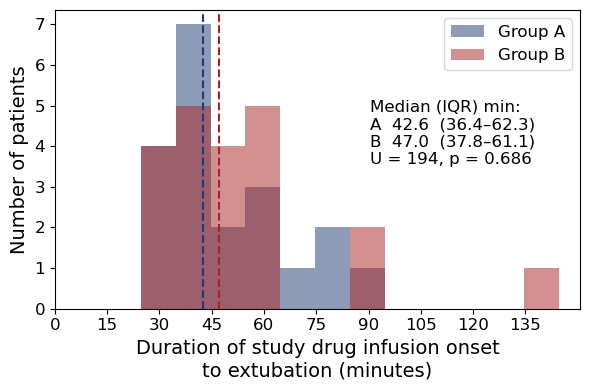

In [17]:
from scipy.stats import mannwhitneyu

# ── 1. collect emergence times (min) by group ────────────────────────────
emerg_time = {"A": [], "B": []}
for pid, t in drug_infusion_to_extubation.items():
    g = group_label[pid]                 # 'A' or 'B'
    emerg_time[g].append(t)              # already in minutes

# convert to numpy arrays for convenience
emerg_time["A"] = np.array(emerg_time["A"])
emerg_time["B"] = np.array(emerg_time["B"])

# ── 2. descriptive stats ─────────────────────────────────────────────────
def median_iqr(arr):
    med = np.median(arr)
    q1, q3 = np.percentile(arr, [25, 75])
    return med, q1, q3

med_A, q1_A, q3_A = median_iqr(emerg_time["A"])
med_B, q1_B, q3_B = median_iqr(emerg_time["B"])

print(f"Group A: median {med_A:.1f} min (IQR {q1_A:.1f}–{q3_A:.1f})")
print(f"Group B: median {med_B:.1f} min (IQR {q1_B:.1f}–{q3_B:.1f})")

# ── 3. Mann–Whitney U test (two-sided) ───────────────────────────────────
u_stat, p_val = mannwhitneyu(emerg_time["A"], emerg_time["B"], alternative="two-sided")
print(f"Mann–Whitney U = {u_stat:.0f}, n₁ = {len(emerg_time['A'])}, "
      f"n₂ = {len(emerg_time['B'])}, p = {p_val:.3f}")

# ── 4. histogram plot ────────────────────────────────────────────────────
BLUE, RED = "#1f3b73", "#a82323"
all_vals   = np.hstack([emerg_time["A"], emerg_time["B"]])
bins       = np.arange(all_vals.min(), all_vals.max() + 10, 10)  # 5-min bins

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(emerg_time["A"], bins=bins, color=BLUE, alpha=0.5, label="Group A")
ax.hist(emerg_time["B"], bins=bins, color=RED,  alpha=0.5, label="Group B")

# median markers
ax.axvline(med_A, color=BLUE, linestyle="--")
ax.axvline(med_B, color=RED,  linestyle="--")

# annotate stats on the figure
stat_text = (f"Median (IQR) min:\n"
             f"A  {med_A:.1f}  ({q1_A:.1f}–{q3_A:.1f})\n"
             f"B  {med_B:.1f}  ({q1_B:.1f}–{q3_B:.1f})\n"
             f"U = {u_stat:.0f}, p = {p_val:.3f}")
ax.text(0.6, 0.7, stat_text, transform=ax.transAxes,
        ha="left", va="top", fontsize=12, bbox=dict(facecolor="white", alpha=0.8, lw=0))

ax.set_xlabel("Duration of study drug infusion onset\nto extubation (minutes)", fontsize=14)
ax.set_ylabel("Number of patients", fontsize=14)
ax.set_xticks(np.arange(0, all_vals.max() + 1, 15))
# ax.set_xticklabels([f"{x}" for x in ax.get_xticks()])
ax.legend(fontsize=12)
ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()


In [ ]:
# Load the patients' surgery information inlcuding the MAC level throughout the surgery, patients extubation time, etc.
surgery_info_file_path = 'E:/Caffeine_data/DE-IDENTIFIED_Caffeine_Study_1-minute_medians.xlsx'
df_surgery_info = pd.read_excel(surgery_info_file_path)

# Make a column for infusion_start per patient
df_surgery_info['infusion_offset'] = (
    df_surgery_info['Study_ID']
      .map(drug_infusion_to_extubation)
      .apply(pd.Timedelta, unit='m')
)

# # # Convert time columns to datetime
# df_surgery_info['Epoch_DT'] = pd.to_datetime(df_surgery_info['Epoch_DT'])
# df_surgery_info['PatientExtubated'] = pd.to_datetime(df_surgery_info['PatientExtubated'])

df_surgery_info['infusion_start'] = (
    df_surgery_info['PatientExtubated'] - df_surgery_info['infusion_offset']
)

# Define the 10-minute baseline window *before* infusion_start
baseline_mask = (
    (df_surgery_info['Epoch_DT'] >= df_surgery_info['infusion_start'] - pd.Timedelta(minutes=10))
    & (df_surgery_info['Epoch_DT'] <  df_surgery_info['infusion_start'])
)

# Calculate mean MAC in that window
baseline_mac = (
    df_surgery_info[baseline_mask]
    .groupby('Study_ID')['MAC - Age-Adjusted Total']
    .mean()
    .rename('baseline_MAC')
    .reset_index()
)

# Merge back on Study_ID
df_surgery_info = df_surgery_info.merge(baseline_mac, on='Study_ID', how='left')

# Filter Study_IDs that are in the dictionary
df_surgery_info = df_surgery_info[df_surgery_info['Study_ID'].isin(drug_infusion_to_extubation.keys())]

# Compute time window dynamically for each Study_ID

df_filtered = df_surgery_info[
    (df_surgery_info['Epoch_DT'] >= df_surgery_info['infusion_start'])
    & (df_surgery_info['Epoch_DT'] <= df_surgery_info['PatientExtubated'])
]
# Display the filtered dataset
df_filtered.head()

,Study_ID,Age,Group,CaseDate,Patient_In_Room,Patient_Intubated,SurgicalIncision,PatientExtubated,Epoch_DT,Propofol_Rate,...,Median_HR_Ekg,Median_HR_PulseOx,Median_IsofluraneET%,Median_SevofluraneET%,Median_NitrousET%,Median_DesfluraneET%,MAC - Age-Adjusted Total,infusion_offset,infusion_start,baseline_MAC
183,CA-01,26,B,2018-07-17,2018-07-17 12:56:32,2018-07-17 13:08:00,2018-07-17 13:42:12,2018-07-17 17:03:28,2018-07-17 16:00:00,NaN,...,92.0,94.0,1.2,NaN,0.0,NaN,0.940449,0 days 01:03:48,2018-07-17 15:59:40,0.940449
184,CA-01,26,B,2018-07-17,2018-07-17 12:56:32,2018-07-17 13:08:00,2018-07-17 13:42:12,2018-07-17 17:03:28,2018-07-17 16:01:00,NaN,...,92.0,92.0,1.2,NaN,0.0,NaN,0.940449,0 days 01:03:48,2018-07-17 15:59:40,0.940449
185,CA-01,26,B,2018-07-17,2018-07-17 12:56:32,2018-07-17 13:08:00,2018-07-17 13:42:12,2018-07-17 17:03:28,2018-07-17 16:02:00,NaN,...,95.0,96.0,1.2,NaN,0.0,NaN,0.940449,0 days 01:03:48,2018-07-17 15:59:40,0.940449
186,CA-01,26,B,2018-07-17,2018-07-17 12:56:32,2018-07-17 13:08:00,2018-07-17 13:42:12,2018-07-17 17:03:28,2018-07-17 16:03:00,NaN,...,98.0,99.0,1.2,NaN,0.0,NaN,0.940449,0 days 01:03:48,2018-07-17 15:59:40,0.940449
187,CA-01,26,B,2018-07-17,2018-07-17 12:56:32,2018-07-17 13:08:00,2018-07-17 13:42:12,2018-07-17 17:03:28,2018-07-17 16:04:00,NaN,...,98.0,99.0,1.2,NaN,0.0,NaN,0.940449,0 days 01:03:48,2018-07-17 15:59:40,0.940449


In [61]:
# Group by Study_ID and extract MAC values as lists
mac_values_per_patient = df_filtered.groupby('Study_ID')['MAC - Age-Adjusted Total'].apply(list).reset_index()

# Display the result
print(mac_values_per_patient)

   Study_ID                           MAC - Age-Adjusted Total
0     CA-01  [0.9404492930145874, 0.9404492930145874, 0.940...
1     CA-02  [0.8927589661163339, 0.9130212269843728, 0.929...
2     CA-03  [0.8626845678466929, 0.9193056151438324, 0.966...
3     CA-04  [1.1965174567661867, 1.1975990816266622, 1.199...
4     CA-05  [1.2344897563557449, 1.2344897563557449, 1.234...
5     CA-06  [0.9440470113999806, 1.0419884880870103, 1.110...
6     CA-07  [0.9882239712101736, 0.9882239712101736, 0.988...
7     CA-09  [1.3522410869619852, 1.3789487980369892, 1.402...
8     CA-10  [0.8389124655296476, 0.8389124655296476, 0.838...
9     CA-11  [0.8870623328010822, 0.8870623328010822, 0.798...
10    CA-13  [1.0384255956469288, 1.0384255956469288, 1.038...
11    CA-14  [0.9285960317205733, 0.9285960317205733, 0.928...
12    CA-15  [0.8653546630391074, 0.8653546630391074, 0.865...
13    CA-18  [0.7596860039112278, 0.7596860039112278, 0.759...
14    CA-19  [0.8133297302721213, 0.8133297302721213, 0

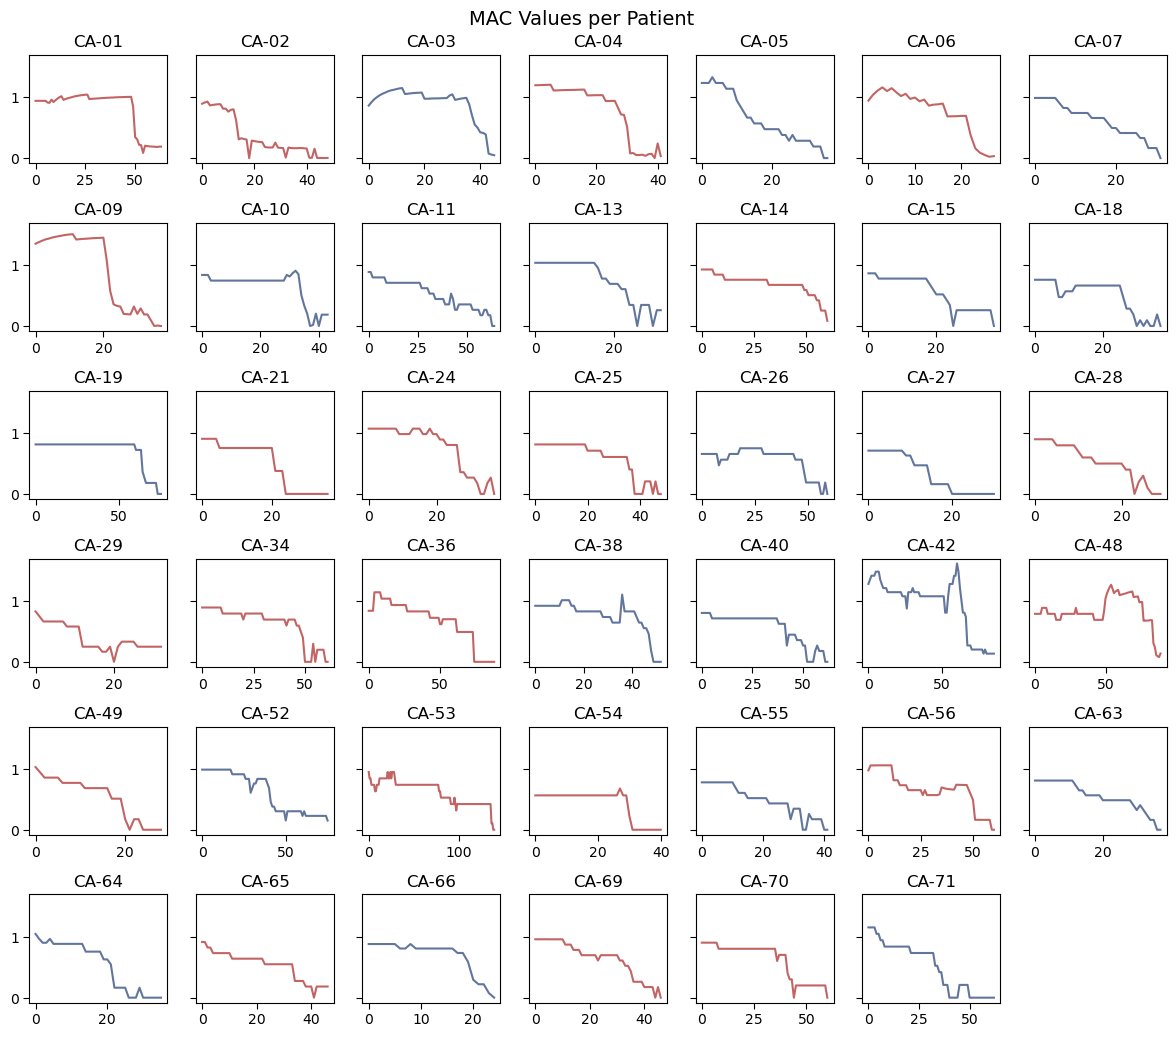

C:\Users\Kourosh\AppData\Local\Temp\ipykernel_5108\2723852501.py:64: RuntimeWarning: All-NaN slice encountered
  median_A, q1_A, q3_A, p5_A, p95_A = np.nanmedian(group_A_mac, axis=0), np.nanpercentile(group_A_mac, 25, axis=0), np.nanpercentile(group_A_mac, 75, axis=0), np.nanpercentile(group_A_mac, 5, axis=0), np.nanpercentile(group_A_mac, 95, axis=0)
c:\Users\Kourosh\.conda\envs\capachinos_env\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
c:\Users\Kourosh\.conda\envs\capachinos_env\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Kourosh\AppData\Local\Temp\ipykernel_5108\2723852501.py:68: RuntimeWarning: Mean of empty slice
  cv_A = np.nanstd(group_A_mac, axis=0) / np.nanmean(group_A_mac, axis=0)
C:\Users\Kourosh\AppData\Local\Temp\ipykernel_5108\2723852501.py:69: RuntimeWarning: inva

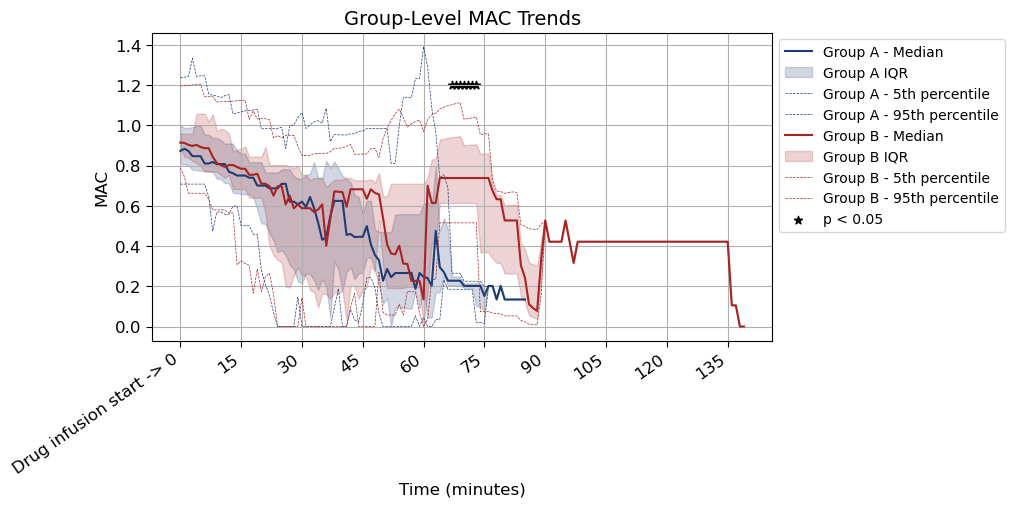

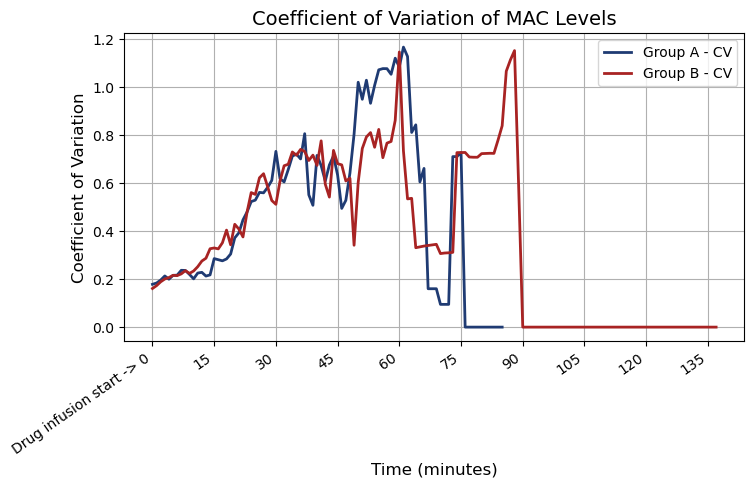

In [62]:
from scipy.stats import ranksums
from scipy.interpolate import interp1d

# Interpolate all series to match max_time
def interpolate_series(series, target_length):
    original_length = len(series)
    x_original = np.linspace(0, 1, original_length)
    x_new = np.linspace(0, 1, target_length)
    f = interp1d(x_original, series, kind='linear', fill_value='extrapolate')
    return f(x_new)

# Define whether to normalize time
NORMALIZE_TIME = False

# Extract unique study IDs
unique_study_ids = mac_values_per_patient['Study_ID'].unique()

# Define grid size
rows, cols = 7, 7
num_plots = len(unique_study_ids)
fig, axes = plt.subplots(rows, cols, figsize=(12, 12), sharex=False, sharey=True)
axes = axes.flatten()

# Plot each patient's MAC time series
for i, study_id in enumerate(unique_study_ids):
    if i >= rows * cols:  # Avoid exceeding grid size
        break

    mac_values = mac_values_per_patient.loc[mac_values_per_patient['Study_ID'] == study_id, 'MAC - Age-Adjusted Total'].values[0]
    axes[i].plot(mac_values, label=f'ID {study_id}', color=BLUE if group_label[study_id] == 'A' else RED, alpha=0.7)
    axes[i].set_title(f'{study_id}', fontsize=12)
    axes[i].tick_params(axis='both', which='both', length=4, labelsize=10)

# Remove empty subplots if any
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

plt.suptitle("MAC Values per Patient", fontsize=14)
plt.tight_layout()
plt.show()

# ---- Group-Level Median and IQR Plot ----
# Create a DataFrame to store MAC values per group
grouped_mac = {'A': [], 'B': []}

for study_id in unique_study_ids:
    group = group_label.get(study_id, None)
    if group in ['A', 'B']:  # Ensure only valid groups are considered
        mac_values = mac_values_per_patient.loc[mac_values_per_patient['Study_ID'] == study_id, 'MAC - Age-Adjusted Total'].values[0]
        grouped_mac[group].append(mac_values)


# Convert lists of lists into 2D NumPy arrays (padded with NaNs to align time points)
max_time = max(map(len, grouped_mac['A'] + grouped_mac['B']))  # Find longest time series
if NORMALIZE_TIME:  
    group_A_mac = np.array([interpolate_series(x, max_time) for x in grouped_mac['A']])
    group_B_mac = np.array([interpolate_series(x, max_time) for x in grouped_mac['B']])
else:
    group_A_mac = np.array([np.pad(x, (0, max_time - len(x)), 'constant', constant_values=np.nan) for x in grouped_mac['A']])
    group_B_mac = np.array([np.pad(x, (0, max_time - len(x)), 'constant', constant_values=np.nan) for x in grouped_mac['B']])


# Compute statistics
median_A, q1_A, q3_A, p5_A, p95_A = np.nanmedian(group_A_mac, axis=0), np.nanpercentile(group_A_mac, 25, axis=0), np.nanpercentile(group_A_mac, 75, axis=0), np.nanpercentile(group_A_mac, 5, axis=0), np.nanpercentile(group_A_mac, 95, axis=0)
median_B, q1_B, q3_B, p5_B, p95_B = np.nanmedian(group_B_mac, axis=0), np.nanpercentile(group_B_mac, 25, axis=0), np.nanpercentile(group_B_mac, 75, axis=0), np.nanpercentile(group_B_mac, 5, axis=0), np.nanpercentile(group_B_mac, 95, axis=0)

# Compute coefficient of variation
cv_A = np.nanstd(group_A_mac, axis=0) / np.nanmean(group_A_mac, axis=0)
cv_B = np.nanstd(group_B_mac, axis=0) / np.nanmean(group_B_mac, axis=0)

# ---- Wilcoxon Rank-Sum Test at Each Time Point ----
p_values = []
for t in range(max_time):
    A_values = group_A_mac[:, t]
    B_values = group_B_mac[:, t]
    
    # Remove NaNs before performing the test
    A_values = A_values[~np.isnan(A_values)]
    B_values = B_values[~np.isnan(B_values)]

    if len(A_values) > 1 and len(B_values) > 1:  # Ensure at least 2 samples in each group
        stat, p = ranksums(A_values, B_values)
    else:
        p = np.nan  # Not enough data for comparison

    p_values.append(p)

p_values = np.array(p_values)

# Plot overlay of group medians and IQR
fig, ax = plt.subplots(1, 1, figsize=(8, 4))  # Corrected this line

# Plot individual traces with fainter, narrower lines
# for trace in group_A_mac:
#     ax.plot(trace, color=BLUE, alpha=0.5, linewidth=0.5)
# for trace in group_B_mac:
#     ax.plot(trace, color=RED, alpha=0.5, linewidth=0.5)

ax.plot(median_A, label="Group A - Median", color=BLUE)
ax.fill_between(range(len(median_A)), q1_A, q3_A, alpha=0.2, color=BLUE, label="Group A IQR")
ax.plot(p5_A, label='Group A - 5th percentile', color=BLUE, linestyle='--', linewidth=0.5)
ax.plot(p95_A, label='Group A - 95th percentile', color=BLUE, linestyle='--', linewidth=0.5)

ax.plot(median_B, label="Group B - Median", color=RED)
ax.fill_between(range(len(median_B)), q1_B, q3_B, alpha=0.2, color=RED, label="Group B IQR")
ax.plot(p5_B, label='Group B - 5th percentile', color=RED, linestyle='--', linewidth=0.5)
ax.plot(p95_B, label='Group B - 95th percentile', color=RED, linestyle='--', linewidth=0.5)

if NORMALIZE_TIME:
    tick_positions = np.linspace(0, max_time, num=11)  # Adjusting for sequence length
else:
    tick_positions = np.arange(0, len(median_B), 15)
ax.set_xticks(tick_positions)

if NORMALIZE_TIME:
    xticklabels = np.arange(0, 1.01, 0.1)
    xticklabels = [int(x*10)/10 for x in xticklabels]
    xticklabels[-1]= 'Extubation -> 1'
else:
    xticklabels = [label.get_text() for label in ax.get_xticklabels()]
xticklabels[0] = "Drug infusion start -> 0"
ax.set_xticklabels(xticklabels, rotation=35, va='top', ha='right')

# Highlight significant differences
significant_timepoints = np.where(p_values < 0.05)[0]
ax.scatter(significant_timepoints, [1.2]*len(significant_timepoints), marker='*', color='black', label="p < 0.05")

if NORMALIZE_TIME:
    ax.set_xlabel("Time (normalized)", fontsize=12, labelpad=-3)
else:    
    ax.set_xlabel("Time (minutes)", fontsize=12)
ax.set_ylabel("MAC", fontsize=12)
ax.set_title("Group-Level MAC Trends", fontsize=14) 
ax.tick_params(labelsize=12, length=4)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid(True)
plt.show()


# ---- Coefficient of Variation Plot ----
fig, ax_cv = plt.subplots(1, 1, figsize=(8, 4))
ax_cv.plot(cv_A, label="Group A - CV", color=BLUE, linewidth=2)
ax_cv.plot(cv_B, label="Group B - CV", color=RED, linewidth=2)

if NORMALIZE_TIME:
    tick_positions = np.linspace(0, max_time, num=11)  # Adjusting for sequence length
else:
    tick_positions = np.arange(0, len(median_B), 15)
ax_cv.set_xticks(tick_positions)

if NORMALIZE_TIME:
    xticklabels = np.arange(0, 1.01, 0.1)
    xticklabels = [int(x*10)/10 for x in xticklabels]
    xticklabels[-1]= 'Extubation -> 1'
else:
    xticklabels = [label.get_text() for label in ax_cv.get_xticklabels()]
xticklabels[0] = "Drug infusion start -> 0"
ax_cv.set_xticklabels(xticklabels, rotation=35, va='top', ha='right')

if NORMALIZE_TIME:
    ax_cv.set_xlabel("Time (Normalized)", fontsize=12, labelpad=-3)
else:    
    ax_cv.set_xlabel("Time (minutes)", fontsize=12)
    
ax_cv.set_ylabel("Coefficient of Variation", fontsize=12)
ax_cv.set_title("Coefficient of Variation of MAC Levels", fontsize=14)
ax_cv.legend()
ax_cv.grid(True)
plt.show()


#### Comparing Age and ASA distributions between the groups

In [63]:
age_asa_file_path = 'E:/Caffeine_data/Caffeine Demographics including ITT.sav'
df_age_asa_info = pd.read_spss(age_asa_file_path)

In [64]:
df_age_asa_info.head()

,StudyID,Age,Group,Gender,WeightKg,ASAScore,AsianRace,CaucasianRace,Hispanic,NonHispanic,...,LapTransverseColectomy,LapSigmoidColectomy,LapPartialColectomy,LapProctocolecotomy,LapLAR,LapColostomy,LapAPR,LapSBR,LapIleostomy,LapAppy
0,CA-01,26.0,B,0.0,107.5,2.0,0.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CA-02,19.0,B,0.0,97.5,2.0,0.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CA-03,73.0,A,1.0,66.0,2.0,0.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,CA-04,59.0,B,1.0,80.0,3.0,0.0,1.0,0.0,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CA-05,57.0,A,0.0,69.0,2.0,0.0,1.0,0.0,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Merging the two data frame
baseline_mac_df = df_filtered.groupby('Study_ID')['baseline_MAC'].mean().reset_index()
baseline_mac_df = baseline_mac_df.rename(columns={'Study_ID': 'StudyID'})

df_merg = pd.merge(
    df_age_asa_info,
    baseline_mac_df,
    on='StudyID',
    how='inner'     # keep all df_age_asa_info rows
)

In [71]:
group_ages = {}
group_asas = {}
group_init_macs = {}

study_ids = df_merg['StudyID']
for group, group_name in zip([groups['A'], groups['B']], ["Group A", "Group B"]):
    curr_group_ages = np.full((len(group),), np.nan)
    curr_group_asas = np.full((len(group),), np.nan)
    curr_group_init_mac = np.full((len(group),), np.nan)
    for p_idx, p_name in enumerate(group):
        curr_group_ages[p_idx] = df_merg.loc[study_ids==p_name, 'Age'].iloc[0]
        curr_group_asas[p_idx] = df_merg.loc[study_ids==p_name, 'ASAScore'].iloc[0]
        curr_group_init_mac[p_idx] = df_merg.loc[study_ids==p_name, 'baseline_MAC'].iloc[0]
    group_ages[group_name] = curr_group_ages
    group_asas[group_name] = curr_group_asas
    group_init_macs[group_name] = curr_group_init_mac

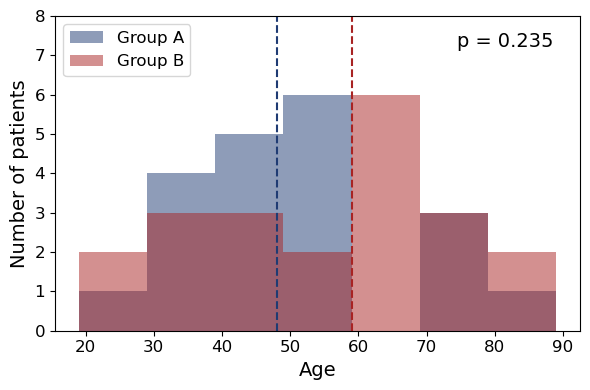

Absolute Standardized Difference (Age): 0.303


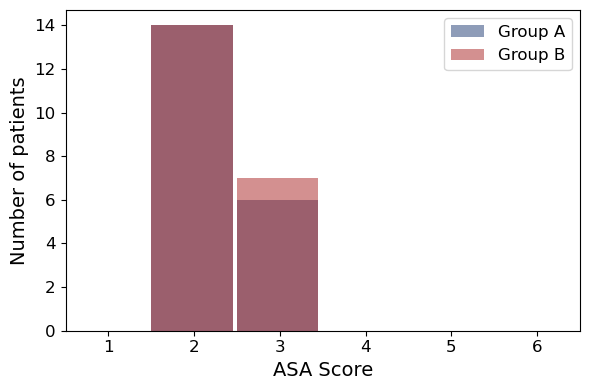

Absolute Standardized Difference (ASA Score): 0.070


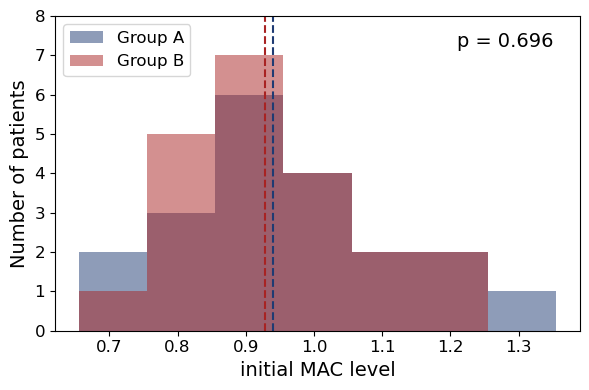

Absolute Standardized Difference (initial MAC): 0.109


In [ ]:
# ─── Constants ────────────────────────────────────────────────────────────────
POSSIBLE_ASAS = np.arange(1, 7)  # 1 through 6

# ─── Age Distribution ─────────────────────────────────────────────
def plot_age_distribution(group_dict, bin_width=10, ylim=(0, 8)):
    """
    Plot age histograms for Group A vs. Group B, with rank‑sum p‑value and medians.
    
    Parameters
    ----------
    group_dict : dict
        {'Group A': array‑like of ages, 'Group B': array‑like of ages}
    bin_width : int
        Width of bins (default=10 years).
    ylim : tuple
        y‑axis limits e.g. (0, 8).
    
    Returns
    -------
    fig, ax
    """
    ages_A = np.asarray(group_dict['Group A'])
    ages_B = np.asarray(group_dict['Group B'])
    
    # bin edges
    min_age = min(ages_A.min(), ages_B.min())
    max_age = max(ages_A.max(), ages_B.max())
    bins = np.arange(min_age, max_age + bin_width, bin_width)
    
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(ages_A, bins=bins, color=BLUE, alpha=0.5,
            label='Group A')
    ax.hist(ages_B, bins=bins, color=RED,  alpha=0.5,
            label='Group B')
    
    # stats & medians
    stat, p_val = ranksums(ages_A, ages_B)
    ax.axvline(np.median(ages_A), color=BLUE, linestyle='--')
    ax.axvline(np.median(ages_B), color=RED,  linestyle='--')
    ax.text(0.95, 0.95, f'p = {p_val:.3f}',
            transform=ax.transAxes, va='top', ha='right', fontsize=14)
    
    # labels & formatting
    ax.set_xlabel('Age', fontsize=14)
    ax.set_ylabel('Number of patients', fontsize=14)
    ax.set_ylim(ylim)
    ax.legend(fontsize=12)
    ax.tick_params(labelsize=12)
    plt.tight_layout()
    
    return fig, ax

# ─── ASA Distribution ──────────────────────────────────────────────
def plot_asa_distribution(group_dict):
    """
    Plot ASA‑score histograms for Group A vs. Group B on the full 1–6 scale.
    
    Parameters
    ----------
    group_dict : dict
        {'Group A': array‑like of ASA scores, 'Group B': array‑like of ASA scores}
    
    Returns
    -------
    fig, ax
    """
    # bins centered on 1–6
    bins = np.arange(POSSIBLE_ASAS[0] - 0.5,
                     POSSIBLE_ASAS[-1] + 0.5 + 1e-8,
                     1.0)
    
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(group_dict['Group A'], bins=bins, color=BLUE, alpha=0.5,
            label='Group A', width=0.95)
    ax.hist(group_dict['Group B'], bins=bins, color=RED,  alpha=0.5,
            label='Group B', width=0.95)
    
    ax.set_xticks(POSSIBLE_ASAS)
    ax.set_xlim(POSSIBLE_ASAS[0] - 0.5, POSSIBLE_ASAS[-1] + 0.5)
    ax.set_xlabel('ASA Score', fontsize=14)
    ax.set_ylabel('Number of patients', fontsize=14)
    ax.legend(fontsize=12)
    ax.tick_params(labelsize=12)
    plt.tight_layout()
    
    return fig, ax

def weighted_mean(x, w):
    return np.sum(w * x) / np.sum(w)

def weighted_var(x, w):
    m = weighted_mean(x, w)
    return np.sum(w * (x - m)**2) / np.sum(w)

def absolute_standardized_difference(x, y, w_x=None, w_y=None):
    """
    If w_x and w_y are None, falls back to the unweighted ASD;
    otherwise computes the weighted ASD.
    """
    x = np.asarray(x)
    y = np.asarray(y)

    # unweighted
    if w_x is None or w_y is None:
        m_x, m_y = x.mean(), y.mean()
        v_x, v_y = x.var(ddof=1), y.var(ddof=1)
    # weighted
    else:
        w_x = np.asarray(w_x)
        w_y = np.asarray(w_y)
        m_x, m_y = weighted_mean(x, w_x), weighted_mean(y, w_y)
        v_x, v_y = weighted_var(x, w_x), weighted_var(y, w_y)

    pooled_sd = np.sqrt((v_x + v_y) / 2)
    return abs(m_x - m_y) / pooled_sd

# Age plot
fig1, ax1 = plot_age_distribution(group_ages)
plt.show()

asd_age = absolute_standardized_difference(group_ages['Group A'],
                                           group_ages['Group B'])
print(f"Absolute Standardized Difference (Age): {asd_age:.3f}")


# ASA plot
fig2, ax2 = plot_asa_distribution(group_asas)
plt.show()

asd_asa = absolute_standardized_difference(group_asas['Group A'],
                                           group_asas['Group B'])
print(f"Absolute Standardized Difference (ASA Score): {asd_asa:.3f}")

# Initial MAC plot
fig1, ax1 = plot_age_distribution(group_init_macs, bin_width=0.1)
ax1.set_xlabel('initial MAC level', fontsize=14)
plt.show()

asd_age = absolute_standardized_difference(group_init_macs['Group A'],
                                           group_init_macs['Group B'])
print(f"Absolute Standardized Difference (initial MAC): {asd_age:.3f}")

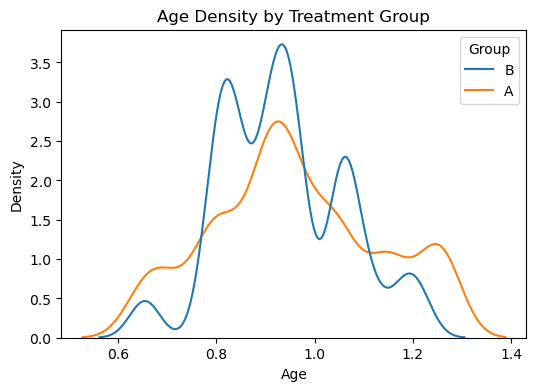

In [70]:

import seaborn as sns

plt.figure(figsize=(6,4))
sns.kdeplot(data=df_filtered, x='baseline_MAC', hue='Group', common_norm=False)
plt.title('Age Density by Treatment Group')
plt.xlabel('Age')
plt.show()

#### Calculate propensity models and inverse probability weights to align (pseudo-) distributions of the covariates between the groups

In [ ]:
import statsmodels.formula.api as smf

# 1) Copy your DataFrame and prepare variables
df = df_merg.copy()
df['ASAScore'] = df['ASAScore'].astype('category')
df['y']        = (df['Group'] == 'A').astype(int)    # binary outcome for “treated”

# 2) Fit unpenalized logistic regression exactly like SAS PROC LOGISTIC
model = smf.logit('y ~ Age + C(ASAScore) + baseline_MAC', data=df).fit(disp=False) # + C(ASAScore)

# df['Age2'] = df['Age']**2
# model = smf.logit('y ~ Age + Age2 ', data=df).fit(disp=False) # + C(ASAScore)
# model = smf.logit('y ~ bs(Age, df=3, degree=3) ', data=df).fit(disp=False) # + C(ASAScore)

# 3) Extract propensity scores
df['ps'] = model.predict(df)  # P(Group A | Age, ASAScore)

# 4) Compute original (unnormalized) IPW that sum to N
N = len(df)
df['ipw_original'] = N * df['ps'] / df['ps'].sum() # NOTE: INVALID

# 5) Compute stabilized IPW
p_treated = df['y'].mean()
df['ipw_stabilized'] = np.where(
    df['y'] == 1,
    p_treated    / df['ps'],
    (1-p_treated)/ (1-df['ps'])
)

# 6) (Optional) check sums
print(f"Sum original weights:   {df['ipw_original'].sum():.0f}")
print(f"Sum stabilized weights: {df['ipw_stabilized'].sum():.0f}")

# 7) If you want to write back to your original DataFrame:
df_merg['ps']               = df['ps']
df_merg['ipw_original']     = df['ipw_original']
df_merg['ipw_stabilized']   = df['ipw_stabilized']

df_final = df_merg[['StudyID', 'Group', 'ASAScore', 'Age', 'baseline_MAC', 'ps', 'ipw_original', 'ipw_stabilized']]


Sum original weights:   41
Sum stabilized weights: 41


In [114]:
# Add the weights to the excel file for caffeine labels
group_labels_file_path = 'E:/Caffeine_data/caffeine_labels.xlsx'
df_labels = pd.read_excel(group_labels_file_path)

# Merge so that each StudyID picks up its Patient_label info
df_out = (
    df_final
      .merge(df_labels, 
             left_on='StudyID', 
             right_on='Patient_Label', 
             how='left')
)

df_out = df_out.drop(columns=['StudyID', 'Group', 'ipw_original'])

first_cols = ['Patient_Label', 'Group_Number', 'Age', 'ASAScore']
rest      = [c for c in df_out.columns if c not in first_cols]
new_order = first_cols + rest

df_out = df_out[new_order]

output_path = 'E:/Caffeine_data/caffeine_labels_ipws.xlsx'
df_out.to_excel(output_path, index=False)

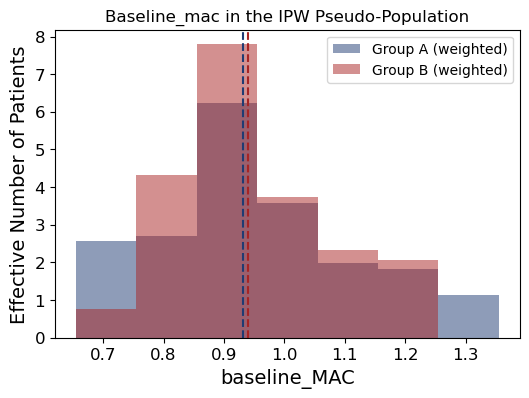

In [97]:
def weighted_median(values, weights):
    """
    Compute the weighted median of 'values' with weights 'weights'.
    """
    # sort both arrays by value
    sorter = np.argsort(values)
    v = values[sorter]
    w = weights[sorter]
    # get the index where cumulative weight ≥ half total weight
    cumw = np.cumsum(w)
    cutoff = 0.5 * np.sum(w)
    return v[cumw >= cutoff][0]

# curr_ipw = 'ipw_original'
curr_ipw = 'ipw_stabilized'

conf_var = 'baseline_MAC'

# define common bins
min_age = df_final[conf_var].min()
max_age = df_final[conf_var].max()
bin_width = 0.1
bins = np.arange(min_age, max_age + bin_width, bin_width)

# split out
maskA = df_final['Group']=='A'
maskB = df_final['Group']=='B'

conf_var_vals_A    = df_final.loc[maskA, conf_var].values
weights_A = df_final.loc[maskA, curr_ipw].values

conf_var_vals_B    = df_final.loc[maskB, conf_var].values
weights_B = df_final.loc[maskB, curr_ipw].values

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(conf_var_vals_A,
         bins=bins, 
         weights=weights_A,
         alpha=0.5, label='Group A (weighted)', color=BLUE)
ax.hist(conf_var_vals_B,
        bins=bins,
        weights=weights_B,
        alpha=0.5, label='Group B (weighted)', color=RED)

stat, p_val = ranksums(conf_var_vals_A, conf_var_vals_B)
# ax.axvline(np.median(conf_var_vals_A), color=BLUE, linestyle='--')
# ax.axvline(np.median(conf_var_vals_B), color=RED,  linestyle='--')

ax.axvline(weighted_median(conf_var_vals_A, weights=weights_A), color=BLUE, linestyle='--')
ax.axvline(weighted_median(conf_var_vals_B, weights=weights_B), color=RED,  linestyle='--')
# ax.text(0.95, 0.95, f'p = {p_val:.3f}',
#         transform=ax.transAxes, va='top', ha='right', fontsize=14)


ax.set_xlabel(conf_var, fontsize=14)
# ax.set_ylabel('Number of Patients', fontsize=14)
ax.set_ylabel('Effective Number of Patients', fontsize=14)
ax.tick_params(labelsize=12)
ax.legend()
# ax.set_title('Age Distribution in the unweighted Population')
ax.set_title(f'{conf_var.capitalize()} in the IPW Pseudo-Population')
plt.show()


In [89]:
np.average(conf_var_vals_A, weights=weights_A)

0.9487165828451005

Text(0.5, 0, 'IPW')

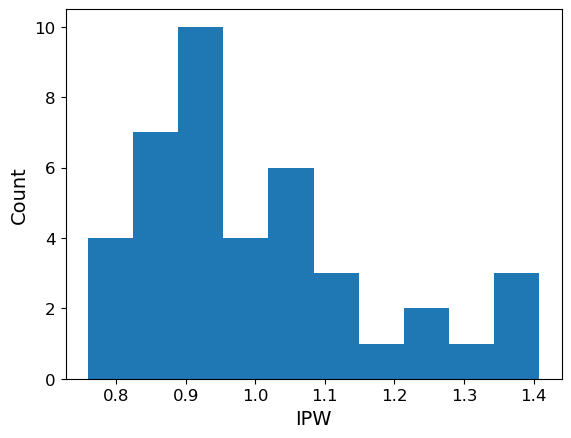

In [107]:
df_final['ipw_stabilized'].plot(kind='hist')
plt.tick_params(labelsize=12)
plt.ylabel('Count', fontsize=14)
plt.xlabel('IPW', fontsize=14)

#### Calculate the absolute standardized difference for the the weighted data

In [103]:
df['ps'] = model.predict(df)
df['w']  = np.where(df['y']==1, 1/df['ps'], 1/(1-df['ps']))

# split out covariate and weights for each group
grpA = df[df['y']==1]
grpB = df[df['y']==0]


conf_var = 'ASAScore'

# unweighted ASD
asd_unw = absolute_standardized_difference(grpA[conf_var], grpB[conf_var])

# weighted ASD
asd_w   = absolute_standardized_difference(
    grpA[conf_var], grpB[conf_var],
    w_x=grpA['w'], w_y=grpB['w']
)

print(f"Unweighted ASD: {asd_unw:.3f}")
print(f"  Weighted ASD: {asd_w:.3f}")

Unweighted ASD: 0.070
  Weighted ASD: 0.004


#### Alternative approach: Subsampling to align the distribution of covariates, e.g., age, initial MAC, ASA, etc across the groups

Kept indices A: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19]
Kept indices B: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20]
Final KS stat = 0.004


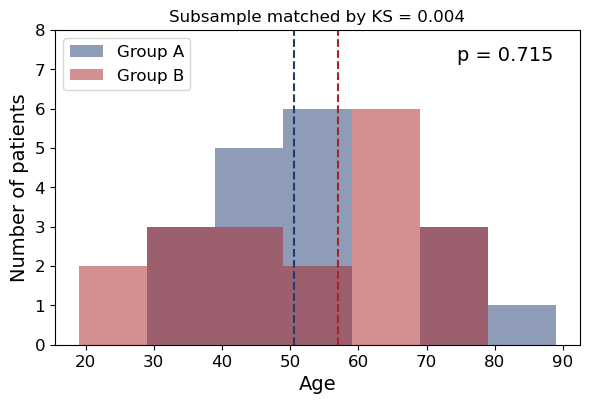

In [ ]:
from scipy.stats import ks_2samp, ranksums

def measure_divergence(x, y, method='asd', w_x= None, w_y = None):
    if method == 'asd':
        return absolute_standardized_difference(x, y, w_x, w_y)
    elif method == 'ks':
        return ks_2samp(x, y).statistic
    else:
        raise ValueError("method must be 'asd' or 'ks'")

def greedy_balance_subsample_with_indices(ages_A, ages_B,
                                         method='asd',
                                         thresh=None):
    """
    Iteratively drop one subject from A or B to reduce the chosen divergence
    (ASD or KS) below `thresh`, returning the largest possible subsample.

    Returns: A_sub, B_sub, idx_A_sub, idx_B_sub, final_divergence
    """
    A = list(ages_A); B = list(ages_B)
    idx_A = list(range(len(ages_A)))
    idx_B = list(range(len(ages_B)))

    # default thresholds
    if thresh is None:
        thresh = 0.1 if method=='asd' else 0.05

    current_div = measure_divergence(A, B, method)

    while current_div > thresh:
        best_drop = 0
        best_group = best_idx = None

        # try dropping from A
        for i in range(len(A)):
            new_div = measure_divergence(np.delete(A, i), B, method)
            drop = current_div - new_div
            if drop > best_drop:
                best_drop, best_group, best_idx = drop, 'A', i

        # try dropping from B
        for i in range(len(B)):
            new_div = measure_divergence(A, np.delete(B, i), method)
            drop = current_div - new_div
            if drop > best_drop:
                best_drop, best_group, best_idx = drop, 'B', i

        if best_drop <= 0:
            break

        if best_group == 'A':
            A.pop(best_idx); idx_A.pop(best_idx)
        else:
            B.pop(best_idx); idx_B.pop(best_idx)

        current_div = measure_divergence(A, B, method)

    return np.array(A), np.array(B), np.array(idx_A), np.array(idx_B), current_div

# ─── Example usage ─────────────────────────────────────────────────────────────

# 1) your raw data
ages_A = np.array(group_ages['Group A'])
ages_B = np.array(group_ages['Group B'])

# 2) pick method='asd' or method='ks'
A_sub, B_sub, idxA, idxB, final_div = greedy_balance_subsample_with_indices(
    ages_A, ages_B, method='asd', thresh=0.01
)
print("Kept indices A:", idxA)
print("Kept indices B:", idxB)
print(f"Final KS stat = {final_div:.3f}")

# 3) reuse your plot_age_distribution
subsample_dict = {'Group A': A_sub, 'Group B': B_sub}
fig, ax = plot_age_distribution(subsample_dict)
ax.set_title(f"Subsample matched by {'KS' if True else 'ASD'} = {final_div:.3f}")
plt.show()


### Comparing with Graciela's IPWs

In [ ]:
graciela_ipws = 'E:/Caffeine_data/Caffeine_IPW_031925.xlsx'
df_graciela = pd.read_excel(graciela_ipws)

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# 1) Copy your DataFrame and prepare variables
df = df_graciela.copy()
df['ASAScore'] = df['ASAScore'].astype('category')
df['y']        = (df['Group'] == 'A').astype(int)    # binary outcome for “treated”

# 2) Fit unpenalized logistic regression exactly like SAS PROC LOGISTIC
model = smf.logit('y ~ Age', data=df).fit(disp=False) # + C(ASAScore)

# 3) Extract propensity scores
df['ps'] = model.predict(df)  # P(Group A | Age, ASAScore)

# 4) Compute original (unnormalized) IPW that sum to N
N = len(df)
df['ipw_original'] = N * df['ps'] / df['ps'].sum()

# 5) Compute stabilized IPW
p_treated = df['y'].mean()
df['ipw_stabilized'] = np.where(
    df['y'] == 1,
    p_treated    / df['ps'],
    (1-p_treated)/ (1-df['ps'])
)

# 6) (Optional) check sums
print(f"Sum original weights:   {df['ipw_original'].sum():.0f}")
print(f"Sum stabilized weights: {df['ipw_stabilized'].sum():.0f}")

# 7) If you want to write back to your original DataFrame:
df_graciela['ps']               = df['ps']
df_graciela['ipw_original']     = df['ipw_original']
df_graciela['ipw_stabilized']   = df['ipw_stabilized']


In [ ]:
df_graciela

,StudyID,Group,Age,ASAScore,Notes_for_Phil_,VAR6,VAR7,_LEVEL_,p,weight,ps,ipw_original,ipw_stabilized
0,CA-03,A,73,2,NaN,NaN,NaN,A,0.417999,0.888245,0.376001,0.799002,1.251561
1,CA-05,A,57,2,NaN,NaN,NaN,A,0.479458,1.018843,0.449839,0.955907,1.046126
2,CA-07,A,34,3,NaN,NaN,NaN,A,0.494166,1.050099,0.559086,1.188057,0.841710
3,CA-10,A,54,2,NaN,NaN,NaN,A,0.491108,1.043601,0.464039,0.986084,1.014112
4,CA-11,A,46,2,NaN,NaN,NaN,A,0.522190,1.109649,0.502132,1.067030,0.937181
5,CA-13,A,42,2,NaN,NaN,NaN,A,0.537681,1.142569,0.521196,1.107542,0.902901
6,CA-15,A,42,2,NaN,NaN,NaN,A,0.537681,1.142569,0.521196,1.107542,0.902901
7,CA-18,A,57,3,NaN,NaN,NaN,A,0.405897,0.862528,0.449839,0.955907,1.046126
8,CA-19,A,49,3,NaN,NaN,NaN,A,0.436208,0.926939,0.487826,1.036631,0.964664
9,CA-23,A,38,2,No EEG Data,NaN,NaN,A,0.553101,1.175334,0.540199,1.147923,0.871139


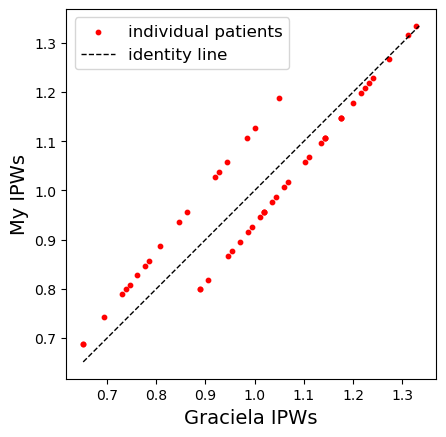

In [ ]:
x = df_graciela['weight']
y = df_graciela['ipw_original']

plt.figure()
plt.scatter(x, y, s=10, color='red', label='individual patients')

# compute limits so the line spans the data range
lims = [
    np.min([x.min(), y.min()]),
    np.max([x.max(), y.max()])
]

# plot identity line
plt.plot(lims, lims, 'k--', linewidth=1, label='identity line')

# optional: force equal aspect ratio
plt.gca().set_aspect('equal', 'box')

plt.xlabel('Graciela IPWs', fontsize=14)
plt.ylabel('My IPWs', fontsize=14)
plt.legend(fontsize=12)
plt.show()

#### Experimenting with developing propensity models separately for ege bins

In [ ]:
import statsmodels.formula.api as smf

# 1) Copy your DataFrame and prepare variables
df = df_merg.copy()
df['y'] = (df['Group']=='A').astype(int)

# 2) Create 5 age‐quintile bins and treat as a categorical
df['age_bin'] = pd.qcut(df['Age'], q=3, labels=False)
df['age_bin'] = df['age_bin'].astype('category')

# 3) Fit unpenalized logistic regression on the age bins
#    This models P(Group A) as a function of which age‐quintile they lie in.
model = smf.logit('y ~ C(age_bin)', data=df).fit(disp=False)

# 4) Extract propensity scores
df['ps'] = model.predict(df)   # P(Group A | age_bin)

# 5) Compute original (unnormalized) IPW that sum to N
N = len(df)
df['ipw_original'] = N * df['ps'] / df['ps'].sum()

# 6) Compute stabilized IPW
p_treated = df['y'].mean()
df['ipw_stabilized'] = np.where(
    df['y']==1,
    p_treated    / df['ps'],
    (1-p_treated)/ (1-df['ps'])
)

# 7) Check sums
print(f"Sum original weights:   {df['ipw_original'].sum():.0f}")
print(f"Sum stabilized weights: {df['ipw_stabilized'].sum():.0f}")

# 8) Write back to your original DataFrame if desired
df_merg['ps']             = df['ps']
df_merg['ipw_original']   = df['ipw_original']
df_merg['ipw_stabilized'] = df['ipw_stabilized']

# 9) Optional: look at your results
df_final = df_merg[['StudyID','Age','Group','ps',
                    'ipw_original','ipw_stabilized']]
print(df_final.head())


Sum original weights:   41
Sum stabilized weights: 41
  StudyID   Age Group        ps  ipw_original  ipw_stabilized
0   CA-01  26.0     B  0.571429      1.171429        1.195122
1   CA-02  19.0     B  0.571429      1.171429        1.195122
2   CA-03  73.0     A  0.285714      0.585714        1.707317
3   CA-04  59.0     B  0.615385      1.261538        1.331707
4   CA-05  57.0     A  0.615385      1.261538        0.792683


#### Experimenting with entropy‐balancing propensity models

In [ ]:
import cvxpy as cp

# 1) Prepare data
df = df_merg.copy()
isA = (df['Group']=='A').values         # boolean mask for Group A
isB = ~isA                             # mask for Group B
age = df['Age'].values

# 2) Compute the treated (Group A) mean age
mean_age_A = age[isA].mean()
nB = isB.sum()

# 3) Define a weight variable only for control subjects
wB = cp.Variable(nB, nonneg=True)

# 4) Constraints:
#   a) Sum of control‐weights = number of controls
#   b) Weighted mean age in controls = mean_age_A
constraints = [
    cp.sum(wB) == nB,
    age[isB] @ wB == mean_age_A * nB
]

# 5) Objective: maximize entropy = sum(–w log w) on controls
obj = cp.Maximize(cp.sum(cp.entr(wB)))

# 6) Solve
prob = cp.Problem(obj, constraints)
prob.solve()

# 7) Build a full‐length weight vector: 1s for treated, wB for controls
weights = np.ones(len(df))
weights[isB] = wB.value

df['ebal_age'] = weights

# 8) Quick check
meanA = np.average(age[isA], weights=weights[isA])
meanB = np.average(age[isB], weights=weights[isB])
print(f"Weighted means: A = {meanA:.2f}, B = {meanB:.2f}")

# 9) (Optional) Plot
min_age = df_final['Age'].min()
max_age = df_final['Age'].max()
bin_width = 10
bins = np.arange(min_age, max_age + bin_width, bin_width)
plt.hist(age[isA], bins=bins, weights=weights[isA],
         alpha=0.5, label='A (unweighted)', color=BLUE)
plt.hist(age[isB], bins=bins, weights=weights[isB],
         alpha=0.5, label='B (ebal_age)', color=RED)
plt.legend()
plt.xlabel('Age')
plt.ylabel('Effective N')
plt.title('Age Balance by Entropy‐Balancing on Controls')
plt.show()
